In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [146]:
import logging
import string
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from replay_trajectory_classification import (
    SortedSpikesClassifier,
    ClusterlessClassifier,
)

from src.figure_utilities import set_figure_defaults
from src.parameters import TRANSITION_TO_CATEGORY

set_figure_defaults()

In [151]:
epoch_key = "gov", 6, 2
ripple_number = 10

In [152]:
import copy

from src.load_data import load_data
from src.parameters import (
    ANIMALS,
    PROBABILITY_THRESHOLD,
    PROCESSED_DATA_DIR,
    SAMPLING_FREQUENCY,
    TRANSITION_TO_CATEGORY,
    continuous_transition_types,
    discrete_diag,
    model,
    model_kwargs,
    movement_var,
    place_bin_size,
    replay_speed,
)
from loren_frank_data_processing import (
    get_multiunit_dataframe,
    get_multiunit_dataframe2,
)
from loren_frank_data_processing.position import (
    make_track_graph,
    EDGE_ORDER,
    EDGE_SPACING,
)
from src.figure3 import plot_clusterless_1D_results, plot_1D_projected_to_2D


data_type, dim = "clusterless", "1D"
animal, day, epoch = epoch_key
data = load_data(epoch_key)

multiunit_times = [
    get_multiunit_dataframe(tetrode_key, ANIMALS)
    for tetrode_key in data["tetrode_info"].index
]
if multiunit_times[0] is None:
    multiunit_times = [
        get_multiunit_dataframe2(tetrode_key, ANIMALS)
        for tetrode_key in data["tetrode_info"].index
    ]

# Fit
is_training = data["position_info"].speed > 4
position = data["position_info"].loc[:, "linear_position"]
track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)

model_name = os.path.join(
    PROCESSED_DATA_DIR, f"{animal}_{day:02}_{epoch:02}_{data_type}_{dim}_model.pkl"
)
classifier = ClusterlessClassifier.load_model(model_name)

results = xr.open_dataset(
    os.path.join(PROCESSED_DATA_DIR, f"{animal}_{day:02d}_{epoch:02d}.nc"),
    group=f"/{data_type}/{dim}/classifier/ripples/",
)

In [153]:
ripple_result = results.sel(ripple_number=ripple_number).dropna("time", how="all")

In [158]:
offset = pd.Timedelta(0.250, "s")

start_time = data["ripple_times"].loc[ripple_number].start_time - offset
end_time = data["ripple_times"].loc[ripple_number].end_time + offset

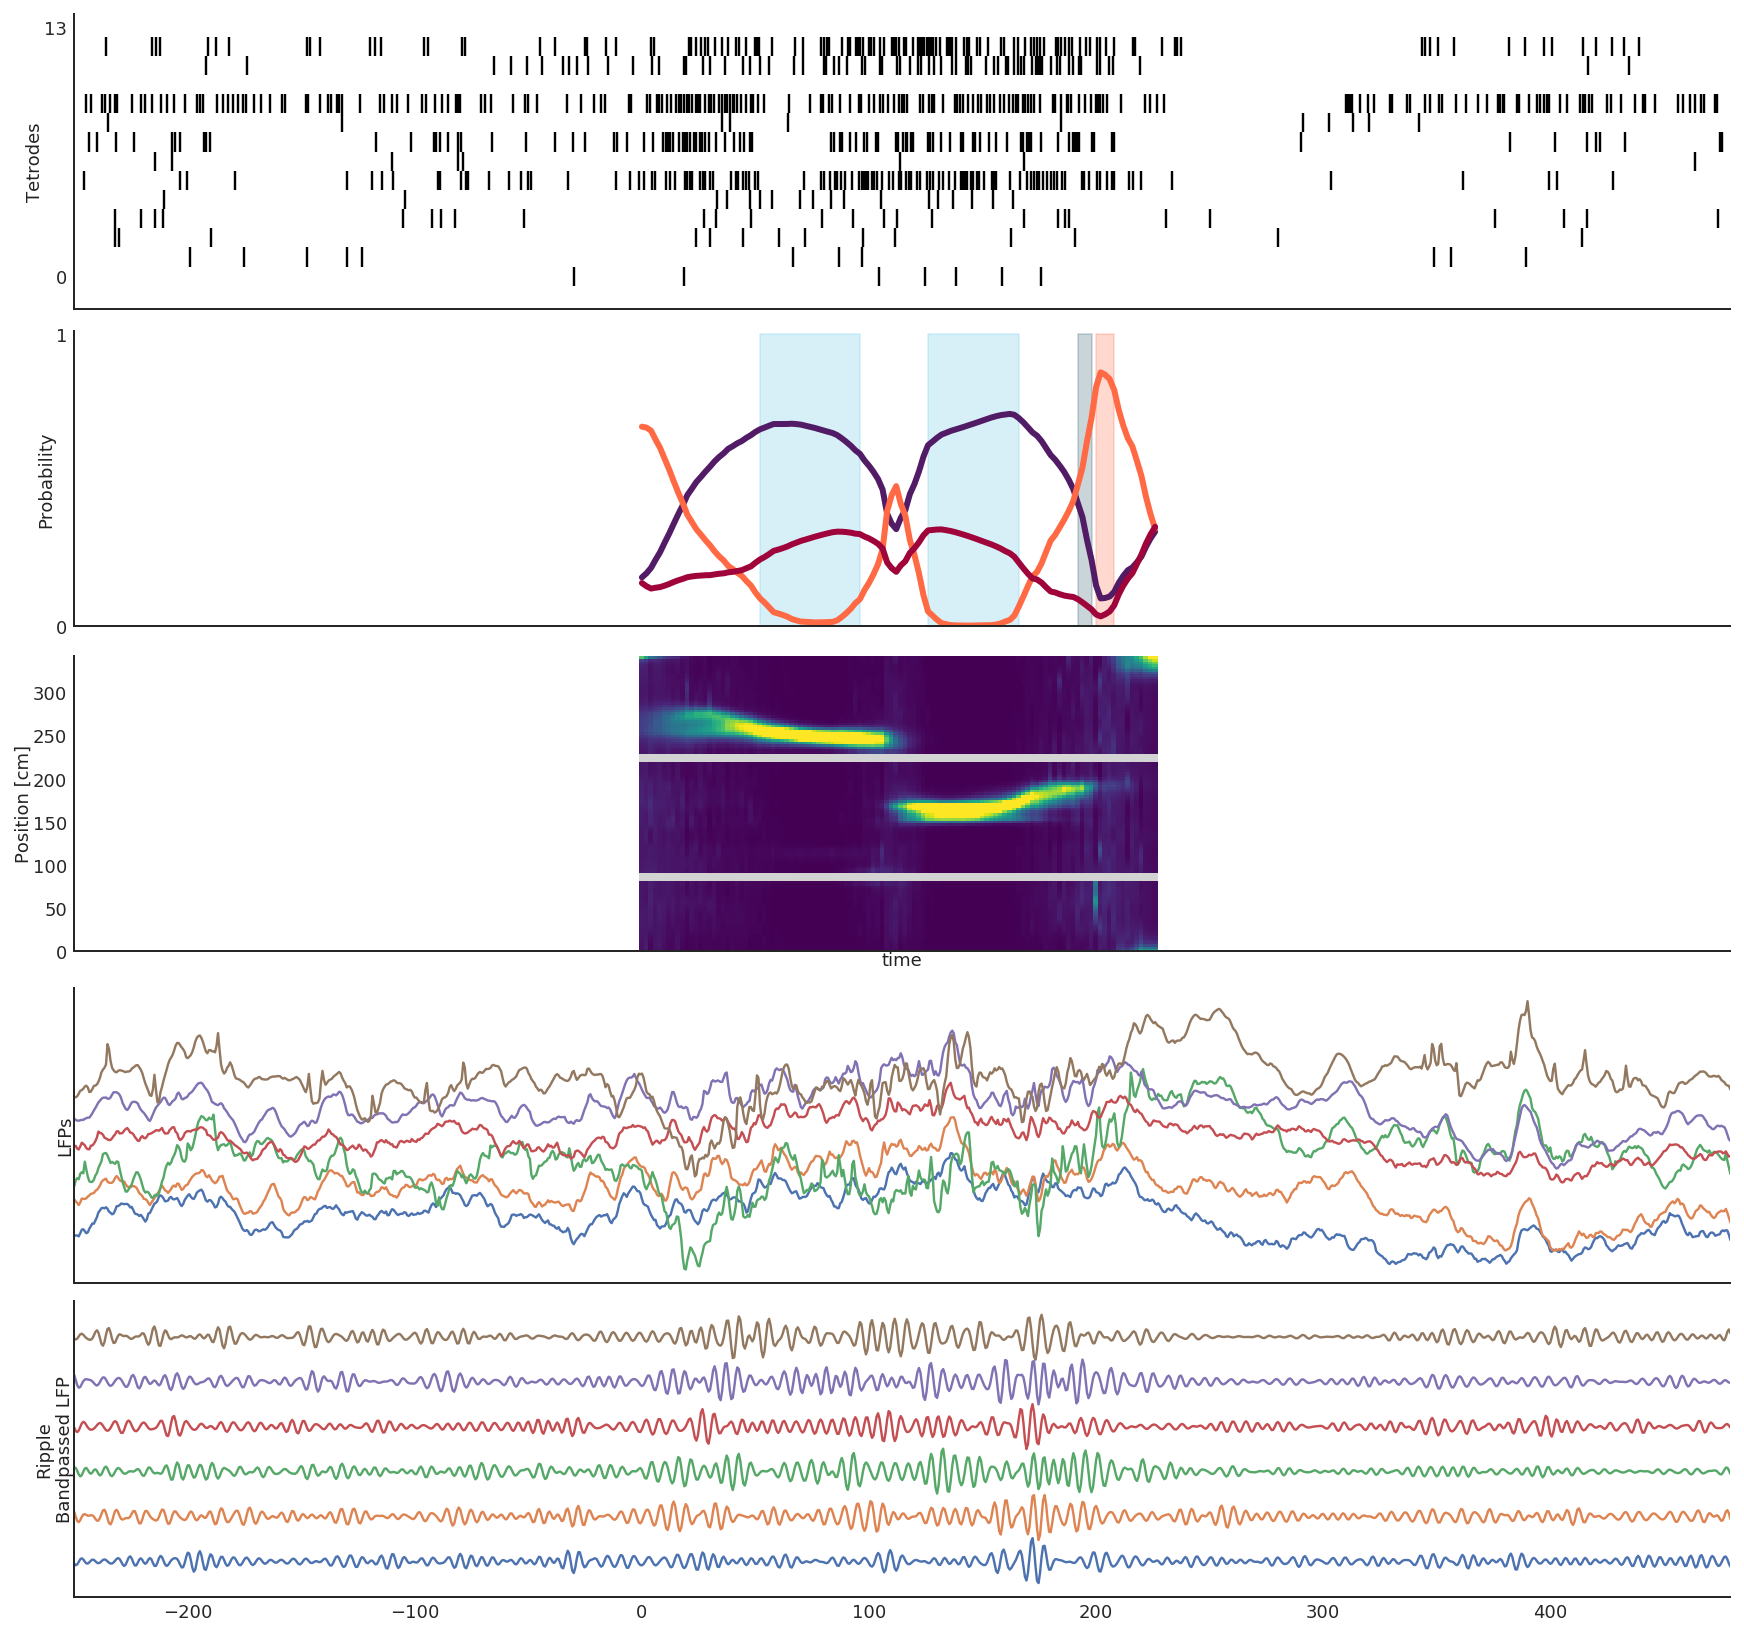

In [163]:
from src.analysis import get_is_classified, get_probability
from src.parameters import PROBABILITY_THRESHOLD, STATE_COLORS
from src.visualization import plot_1D_wtrack_landmarks, plot_2D_position_with_color_time


fig, axes = plt.subplots(
    5, 1, figsize=(12, 2.25 * 5), constrained_layout=True, sharex=True,
)
plt.ticklabel_format(useOffset=False)
MILLISECONDS_TO_SECONDS = 1000

# axis 0
n_tetrodes = len(multiunit_times)
ripple_duration = (
    MILLISECONDS_TO_SECONDS * (end_time - start_time) / np.timedelta64(1, "s")
)

axes[0].eventplot(
    [
        MILLISECONDS_TO_SECONDS
        * (
            multiunit.loc[start_time:end_time].index
            - data["ripple_times"].loc[ripple_number].start_time
        )
        / np.timedelta64(1, "s")
        for multiunit in multiunit_times
    ],
    color="black",
)

# axes[0].set_xlim((0, ripple_duration))
# axes[0].set_xticks((0, ripple_duration))

axes[0].set_yticks((0, n_tetrodes))
axes[0].set_ylabel("Tetrodes")

# axis 1
probability = ripple_result.acausal_posterior.sum(["position"])

for state, prob in zip(ripple_result.state.values, probability.values.T):
    axes[1].plot(
        MILLISECONDS_TO_SECONDS * probability.time / np.timedelta64(1, "s"),
        prob,
        linewidth=3,
        color=STATE_COLORS[state],
    )

axes[1].set_ylim((0, 1.01))
axes[1].set_yticks((0, 1))
axes[1].set_ylabel("Probability")
probability2 = get_probability(ripple_result)
is_classified = get_is_classified(probability2, PROBABILITY_THRESHOLD)

time = MILLISECONDS_TO_SECONDS * probability.time / np.timedelta64(1, "s")

for state, is_class in zip(is_classified.state.values, is_classified.values.T):
    if is_class.sum() > 0:
        axes[1].fill_between(
            time,
            is_class,
            where=is_class.astype(bool),
            alpha=0.25,
            color=STATE_COLORS[state],
        )

# axis 2
cmap = copy.copy(plt.cm.get_cmap("viridis"))
cmap.set_bad(color="lightgrey", alpha=1.0)
(
    ripple_result.assign_coords(
        time=lambda ds: MILLISECONDS_TO_SECONDS * ds.time / np.timedelta64(1, "s")
    )
    .acausal_posterior.sum("state")
    .where(classifier.is_track_interior_)
    .plot(
        x="time",
        y="position",
        robust=True,
        add_colorbar=False,
        zorder=0,
        rasterized=True,
        cmap=cmap,
        ax=axes[2],
    )
)
axes[2].set_title("")

# ripple_position = data["position_info"].loc[start_time:end_time, "linear_position"]
# max_time = (
#     MILLISECONDS_TO_SECONDS * probability.time / np.timedelta64(1, "s")
# ).max()
# axes[2].annotate(
#     "",
#     xy=(max_time, ripple_position.mean()),
#     xycoords="data",
#     xytext=(max_time + ripple_duration * 0.04, ripple_position.mean()),
#     textcoords="data",
#     arrowprops=dict(shrink=0.00, color="red"),
#     horizontalalignment="left",
#     verticalalignment="center",
#     color="red",
#     zorder=200,
# )
# axes[2].set_xlim((0, max_time))
# axes[2].set_xticks((0, np.round(ripple_duration).astype(int)))
# axes[2].set_xlabel("Time [ms]")

# plot_1D_wtrack_landmarks(data, max_time, ax=axes[2])
axes[2].set_ylabel("Position [cm]")

is_ripple_lfp = data["tetrode_info"].validripple == 1
ripple_lfp_ind = np.nonzero(is_ripple_lfp)[0][0]

lfp_time = data["ripple_lfps"].loc[start_time:end_time].index.total_seconds()
lfp_time -= data["ripple_times"].loc[ripple_number].start_time.total_seconds()
lfp_time *= MILLISECONDS_TO_SECONDS
lfps = data["ripple_lfps"].loc[start_time:end_time]
# axes[-2].plot(lfp_time, lfps)
# lfps /= np.ptp(np.asarray(data["ripple_lfps"]), axis=0)
# lfps /= np.ptp(np.asarray(lfps), axis=0)
lfps /= np.diff(
    np.percentile(np.asarray(data["ripple_lfps"]), [25, 75], axis=0), axis=0
)
for lfp_ind, lfp in enumerate(lfps.values.T):
    axes[-2].plot(lfp_time, lfp + lfp_ind + 1)
axes[-2].set_ylabel("LFPs")
axes[-2].set_yticks([])
axes[-2].set_yticklabels([], [])

ripple_filtered_lfps = np.asarray(
    data["ripple_filtered_lfps"].loc[start_time:end_time, :]
)
ripple_filtered_lfps /= np.ptp(
    np.asarray(data["ripple_filtered_lfps"].loc[start_time:end_time, :]), axis=0
)
for lfp_ind, lfp in enumerate(ripple_filtered_lfps.T):
    axes[-1].plot(lfp_time, lfp + lfp_ind + 1)
# axes[-1].plot(lfp_time, ripple_band_lfps)
axes[-1].set_ylabel("Ripple\nBandpassed LFP")
axes[-1].set_yticks([])
axes[-1].set_yticklabels([], [])

plt.xlim((lfp_time.min(), lfp_time.max()))


sns.despine()

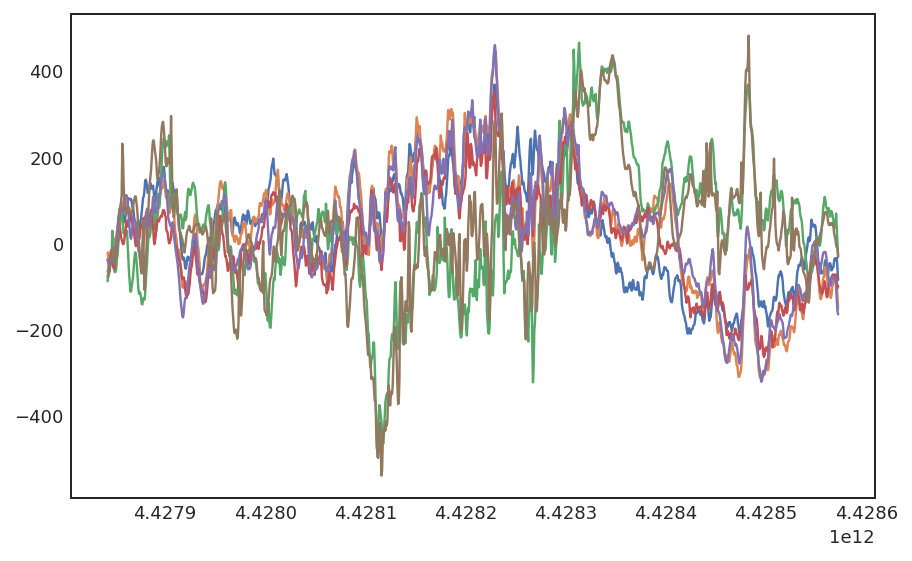

In [160]:
lfps = data["ripple_lfps"].loc[start_time:end_time]

plt.plot(lfps)

(99,)